### The following is the code used to solve the Moving Cost MDP Variation presented in the paper

#### ** This code is identical apart from the egreedy algortithm, which uses an epsilon greedy appraoch, and the new reward function **
- Here we will import the relevant packages
- We will define the MDP as defined in the paper
- We will then compute the results (fixed seed of 42 to ensure replicability)
- This algorithm is much faster and has a better rate of covergence

Full reference list:
    
    

In [ ]:
import itertools
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scienceplots
import torch

plt.style.use('science')
plt.rcParams['figure.figsize'] = [6, 4]

In [2]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [3]:
print(torch.version.cuda)

11.8


In [4]:

from enum import Enum


class Location(Enum):
    POOR_COUNTRY = 0
    RICH_COUNTRY = 1


class Education(Enum):
    HIGH_SCHOOL = 0
    COLLEGE = 1


class CurrentLocation(Enum):
    HOME_COUNTRY = 0
    AWAY = 1


class RelationshipStatus(Enum):
    MARRIED = 0
    SINGLE = 1


class Action(Enum):
    MIGRATE = 0
    NOT_MIGRATE = 1


class StateSpace:
    def __init__(self, phi, y, c, omega, tau, epsilon):
        self.phi = phi
        self.y = y
        self.c = c
        self.omega = omega
        self.tau = tau
        self.epsilon = epsilon

    def __eq__(self, other):
        if isinstance(other, StateSpace):
            return self.phi == other.phi and self.y == other.y and self.c == other.c and self.omega == other.omega and self.tau == other.tau and self.epsilon == other.epsilon
        return False

    def __hash__(self):
        return hash((self.phi, self.y, self.c, self.omega, self.tau, self.epsilon))

    def to_tensor(self):
        phi_tensor = torch.tensor(1 if self.phi == Location.RICH_COUNTRY else 0, dtype=torch.float32)
        y_tensor = torch.tensor(self.y, dtype=torch.float32)
        c_tensor = torch.tensor(self.c, dtype=torch.float32)
        omega_tensor = torch.tensor(1 if self.omega == Education.COLLEGE else 0, dtype=torch.float32)
        tau_tensor = torch.tensor(1 if self.tau == CurrentLocation.HOME_COUNTRY else 0, dtype=torch.float32)
        epsilon_tensor = torch.tensor(1 if self.epsilon == RelationshipStatus.MARRIED else 0, dtype=torch.float32)
        return torch.stack([phi_tensor, y_tensor, c_tensor, omega_tensor, tau_tensor, epsilon_tensor])

In [5]:
import numpy as np

def transition_probability(s, next_s, a, p1, p2, p3):
    probs = np.zeros(len(states))

    if a == Action.MIGRATE:
        for i, state in enumerate(states):
            if s == state:
                probs[i] = (1 - p1) if s.omega == Education.COLLEGE and s.tau == CurrentLocation.HOME_COUNTRY and s.epsilon == RelationshipStatus.SINGLE and s.phi == Location.RICH_COUNTRY else (1 - p2)
            elif s.omega == Education.COLLEGE and s.tau == CurrentLocation.HOME_COUNTRY and s.epsilon == RelationshipStatus.SINGLE and s.phi == Location.RICH_COUNTRY:
                probs[i] = p1
            else:
                probs[i] = p2

    else:
        for i, state in enumerate(states):
            if s == state:
                probs[i] = p3
            else:
                probs[i] = (1 - p3) / (len(states) - 1)

    probs /= np.sum(probs)
    return probs[states.index(next_s)]



In [6]:
states = list(itertools.product(Location, np.linspace(0, 2, 3), np.linspace(0, 2, 3), Education, CurrentLocation, RelationshipStatus))
states = [StateSpace(*s) for s in states]
actions = list(Action)


p1 = 0.87 #Probability of succesfully migrate if state has conditions //Proxied by Uk Visa success rate
p2 = 0.66 #Probability of succefully migrate //proxied by avg UK asylum offer rate
p3 = 0.90 #Probability of succefully not migrating given chosen not to

#### We now include lambda(shock) into our MDP:

In [7]:
def reward_function(s, next_s, a, shock):
    YC = next_s.y - next_s.c
    reward = YC*10

    # Additional rewards or penalties based on other state variables
    if next_s.tau == CurrentLocation.HOME_COUNTRY:
        reward += 30
    if next_s.epsilon == RelationshipStatus.SINGLE:
        reward += 10
    if next_s.omega == Education.COLLEGE:
        reward += 20
    if next_s.phi == Location.RICH_COUNTRY:
        reward += 50
    # Normalize reward
    max_reward = 30 + 10 + 20 + 50 + 20
    min_reward = -2
    new_reward = (reward - min_reward) / (max_reward - min_reward)
    
    
    if a == Action.MIGRATE:
        new_reward -= shock
    
    return new_reward

In [8]:
# Precompute transition probabilities
transition_probabilities = {}
for s in states:
    for a in actions:
        for next_s in states:
            transition_probabilities[(s, a, next_s)] = transition_probability(s, next_s, a, p1, p2, p3)

This section borrows from Barton and Sutton(2015) and from Fedus et al (2019)

In [9]:
def calculate_gamma_intervals(beta, gamma_max, n_gamma):
    epsilon = 1e-8 #To avoid Beta = 0
    b = np.exp(np.log(1 - gamma_max ** (1 / (beta + epsilon))) / n_gamma)
    gamma_values = [(1 - b ** i) ** (beta + epsilon) for i in range(n_gamma + 1)]
    return gamma_values


In [10]:
import numpy as np
import torch

def egreedy(states, actions, transition_probabilities, reward_function, beta, n_episodes=500, alpha=0.1, epsilon=0.1, gamma_max=0.99, n_gamma=10, max_steps=200):
    gamma_values = np.array(calculate_gamma_intervals(beta, gamma_max=gamma_max, n_gamma=n_gamma))
    eps = 1e-16
    gamma_weights = (1 / (beta + eps)) * gamma_values ** (1 / (beta + eps) - 1)
    gamma_diffs = np.diff(gamma_values)

    Q = {s: {a: 0 for a in actions} for s in states}
    
    for episode in range(n_episodes):
        s = StateSpace(Location.POOR_COUNTRY, 0, 2, Education.HIGH_SCHOOL, CurrentLocation.HOME_COUNTRY, RelationshipStatus.SINGLE)  # Initialize the starting state
        steps = 0

        while steps < max_steps:
            if np.random.rand() < epsilon:
                a = np.random.choice(actions)  # Choose action randomly
            else:
                a = max(Q[s], key=Q[s].get)  # Choose action with the highest Q-value
            
            next_s = np.random.choice(states, p=[transition_probabilities[(s, a, next_s)] for next_s in states])
            reward = reward_function(s, next_s, a, np.random.lognormal(-7, 0.5))  # Lognormal shock
            
            target = reward + np.sum(np.array([gamma_values[:-1] * Q[next_s][max(Q[next_s], key=Q[next_s].get)]]) * gamma_diffs * gamma_weights[:-1])

            Q[s][a] += alpha * (target - Q[s][a])  # Update Q-value

            s = next_s  # Update state
            steps += 1

    policy = {s: max(Q[s], key=Q[s].get) for s in states}
    V = {s: max(Q[s].values()) for s in states}

    return V, policy



In [11]:
def simulate(initial_state, policy, num_iterations, beta, gam, p1, p2, p3, transition_probabilities):
    expected_utility = []
    migrate_count = 0
    rewards = []
    states_sequence = []
    actions_sequence = []

    state = initial_state
    for i in range(num_iterations):
        action = policy[state]
        probabilities = [transition_probabilities[(state, action, s_prime)] for s_prime in states]
        next_state = np.random.choice(states, p=probabilities)
        shock = np.random.lognormal(-7,0.5)
        reward = reward_function(state, next_state, action, shock)
        
        #print(f"Iteration: {i + 1}")
        #print(f"State: {state.__dict__}")
        #print(f"Action: {action}")
        #print(f"Next State: {next_state.__dict__}")
        #print(f"Reward: {reward}")
        #print()

        if action == Action.MIGRATE:
            migrate_count += 1

        rewards.append(reward)
        
        # Append current state and action to the sequences
        states_sequence.append(state.__dict__)
        actions_sequence.append(action)

        # Calculate expected utility using hyperbolic discounting
        discounted_rewards = [beta * (r * (gam **t)) for t, r in enumerate(rewards[1:], start=1)]
        expected_utility_t = rewards[0] + sum(discounted_rewards)
        expected_utility.append(expected_utility_t)

        state = next_state
        
    migration_percentage = ((migrate_count / num_iterations) * 100)
    return rewards, expected_utility, migration_percentage, states_sequence, actions_sequence

In [12]:
def plot_results(beta, rewards, expected_utility):
    plt.figure(figsize=(18, 6))

    # Plot rewards
    plt.subplot(131)
    plt.plot(rewards)
    plt.xlabel('Iteration')
    plt.ylabel('Reward')
    plt.title(f'Beta: {beta}, Rewards (MC)')

    # Plot reward distribution
    plt.subplot(132)
    plt.hist(rewards, bins=10, density=True)
    plt.xlabel('Reward')
    plt.ylabel('Probability')
    plt.title(f'Beta: {beta}, Reward Distribution (MC)')

    # Plot expected utility
    plt.subplot(133)
    plt.plot(expected_utility)
    plt.xlabel('Iteration')
    plt.ylabel('Expected Utility')
    plt.title(f'Beta: {beta}, Expected Utility (MC)')

    plt.tight_layout()
    plt.show()

In [13]:
def calculate_migration_percentage_matrix(states_sequence, actions_sequence):
    counts = {
        "poor_country": 0,
        "rich_country": 0,
        "college": 0,
        "high_school": 0,
        "single": 0,
        "married": 0,
        "home_country": 0,
        "away": 0
    }
    
    migrate_counts = counts.copy()

    for state, action in zip(states_sequence, actions_sequence):
        if state['phi'] == Location.POOR_COUNTRY:
            counts["poor_country"] += 1
            if action == Action.MIGRATE:
                migrate_counts["poor_country"] += 1
        elif state['phi'] == Location.RICH_COUNTRY:
            counts["rich_country"] += 1
            if action == Action.MIGRATE:
                migrate_counts["rich_country"] += 1

        if state['omega'] == Education.COLLEGE:
            counts["college"] += 1
            if action == Action.MIGRATE:
                migrate_counts["college"] += 1
        elif state['omega'] == Education.HIGH_SCHOOL:
            counts["high_school"] += 1
            if action == Action.MIGRATE:
                migrate_counts["high_school"] += 1

        if state['epsilon'] == RelationshipStatus.SINGLE:
            counts["single"] += 1
            if action == Action.MIGRATE:
                migrate_counts["single"] += 1
        elif state['epsilon'] == RelationshipStatus.MARRIED:
            counts["married"] += 1
            if action == Action.MIGRATE:
                migrate_counts["married"] += 1

        if state['tau'] == CurrentLocation.HOME_COUNTRY:
            counts["home_country"] += 1
            if action == Action.MIGRATE:
                migrate_counts["home_country"] += 1
        elif state['tau'] == CurrentLocation.AWAY:
            counts["away"] += 1
            if action == Action.MIGRATE:
                migrate_counts["away"] += 1

    migration_percentages = {k: (migrate_counts[k] / counts[k]) if counts[k] > 0 else 0 for k in counts}

    return np.array([list(migration_percentages.values())])




### This will run the actual MDP:

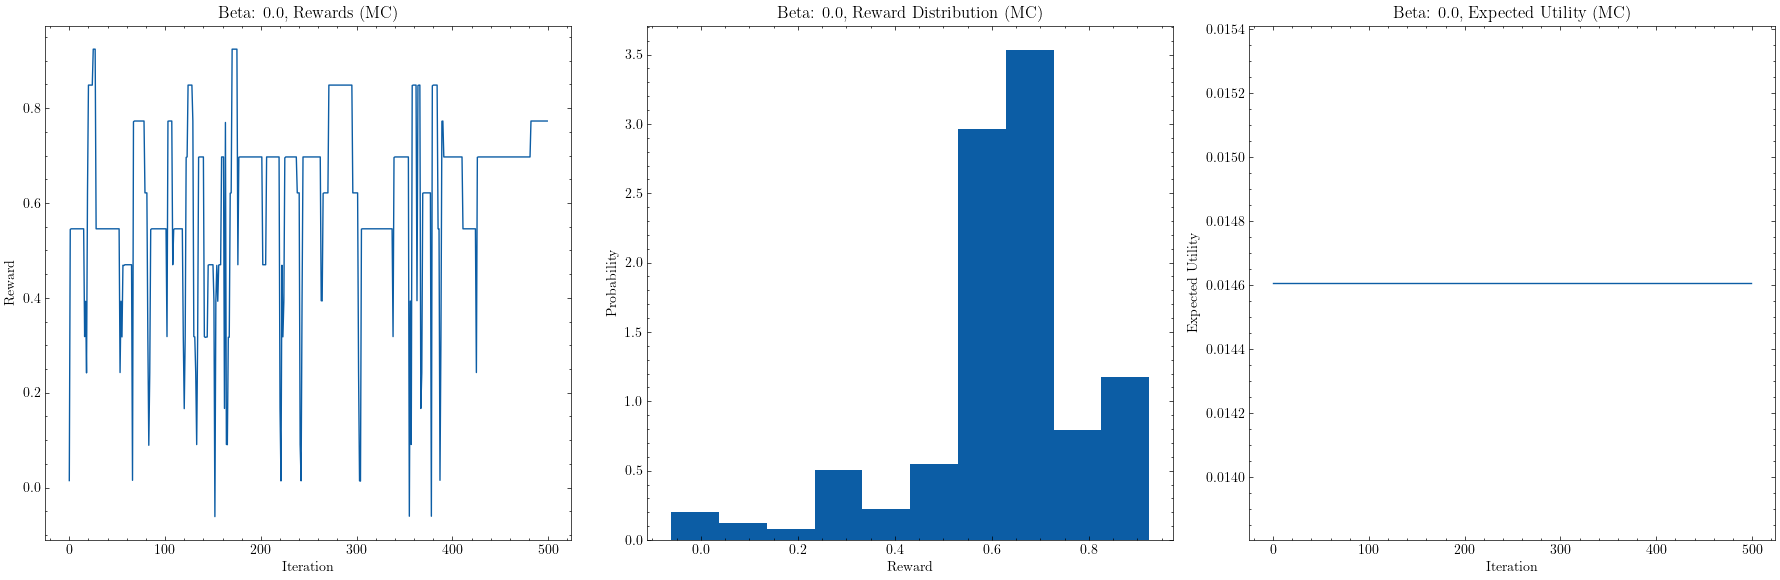

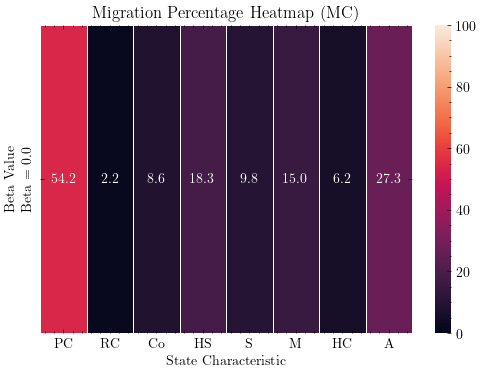

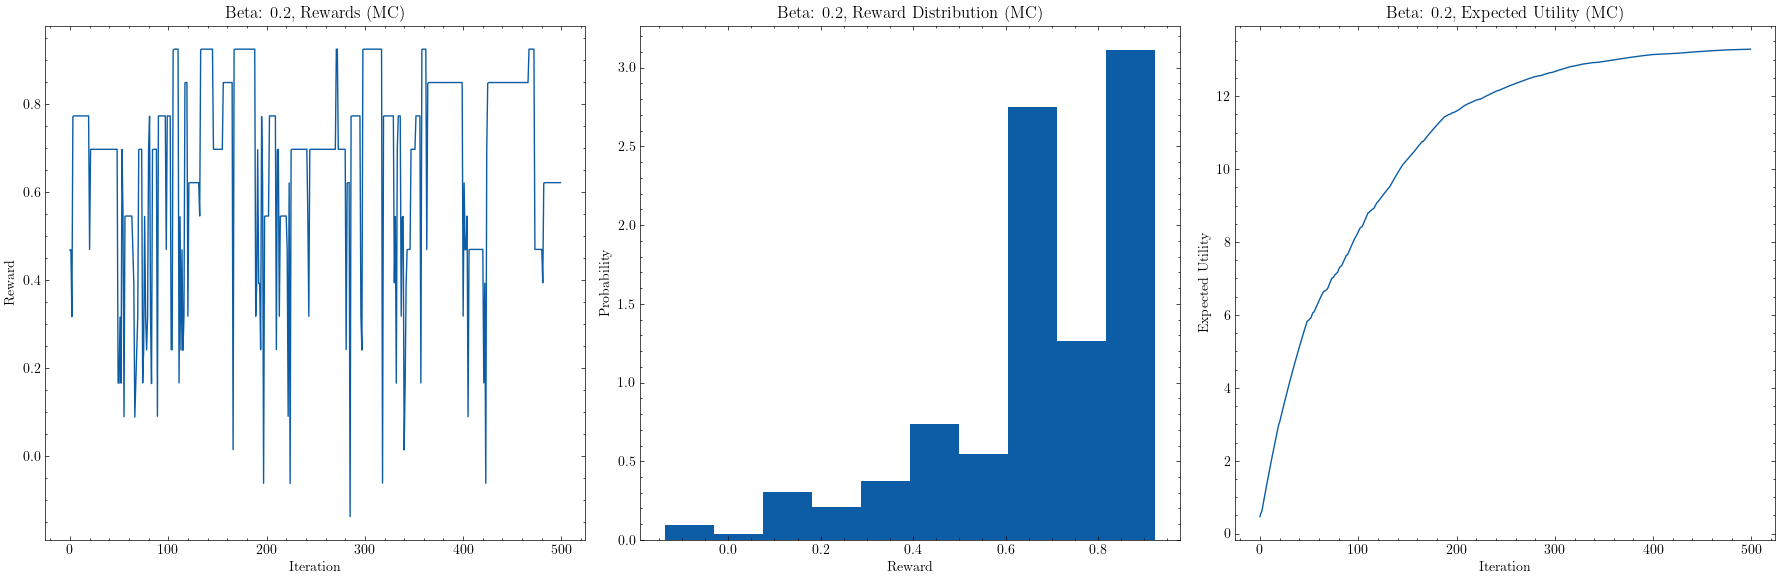

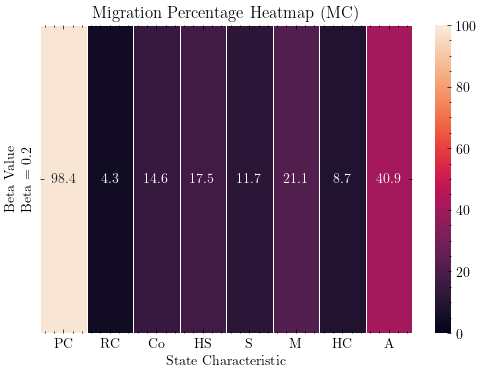

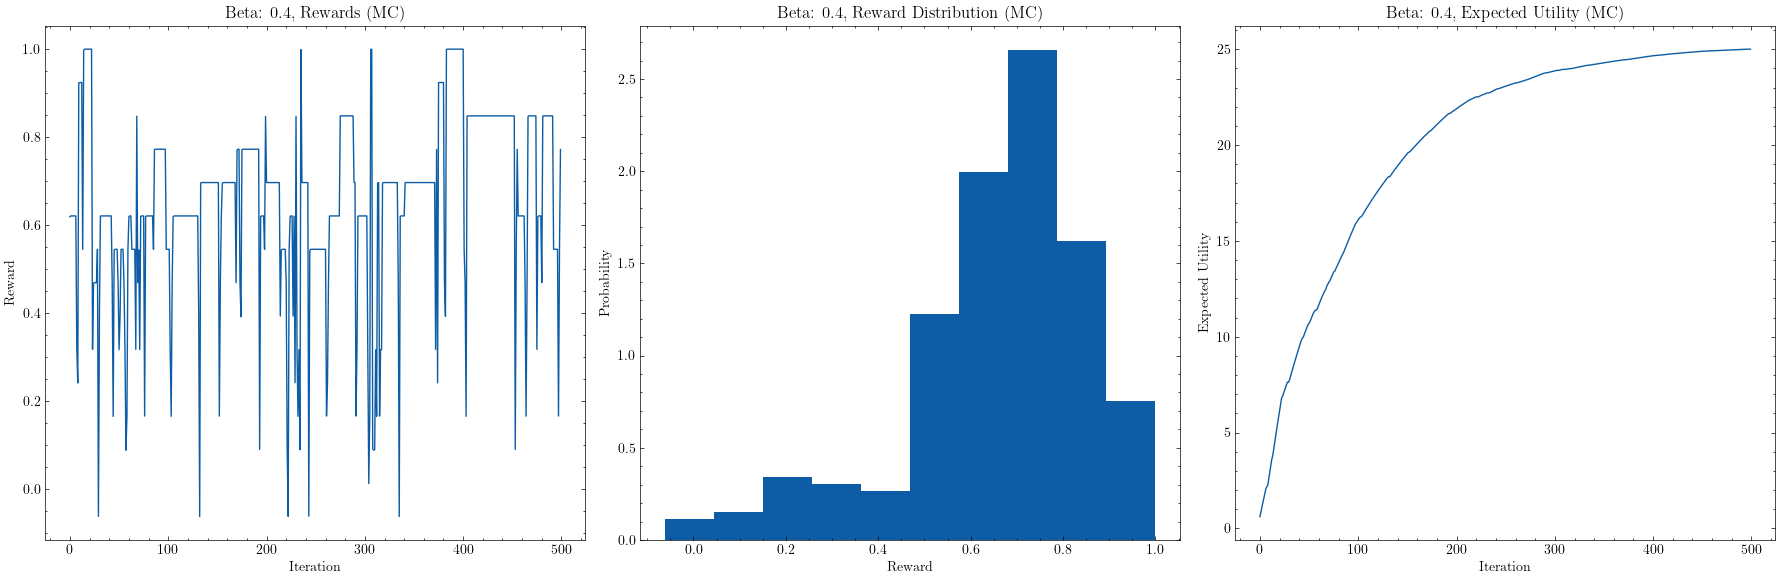

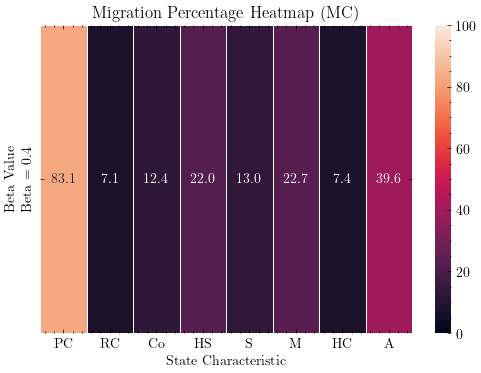

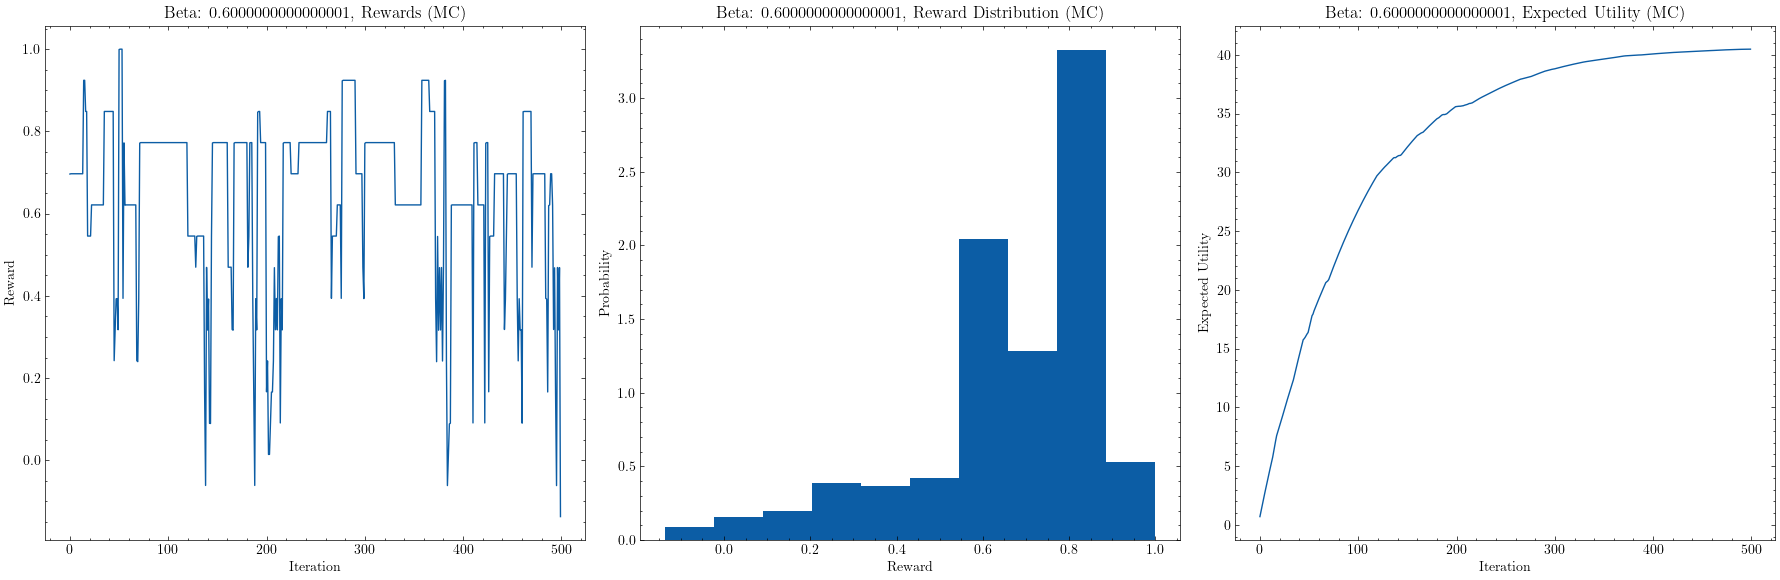

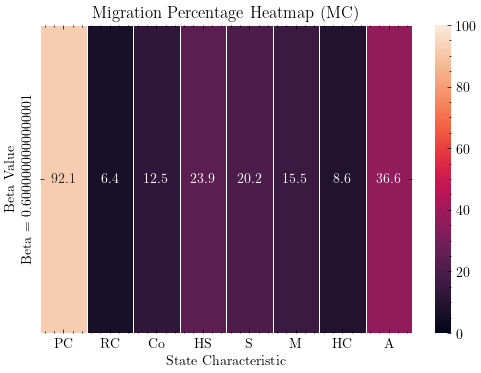

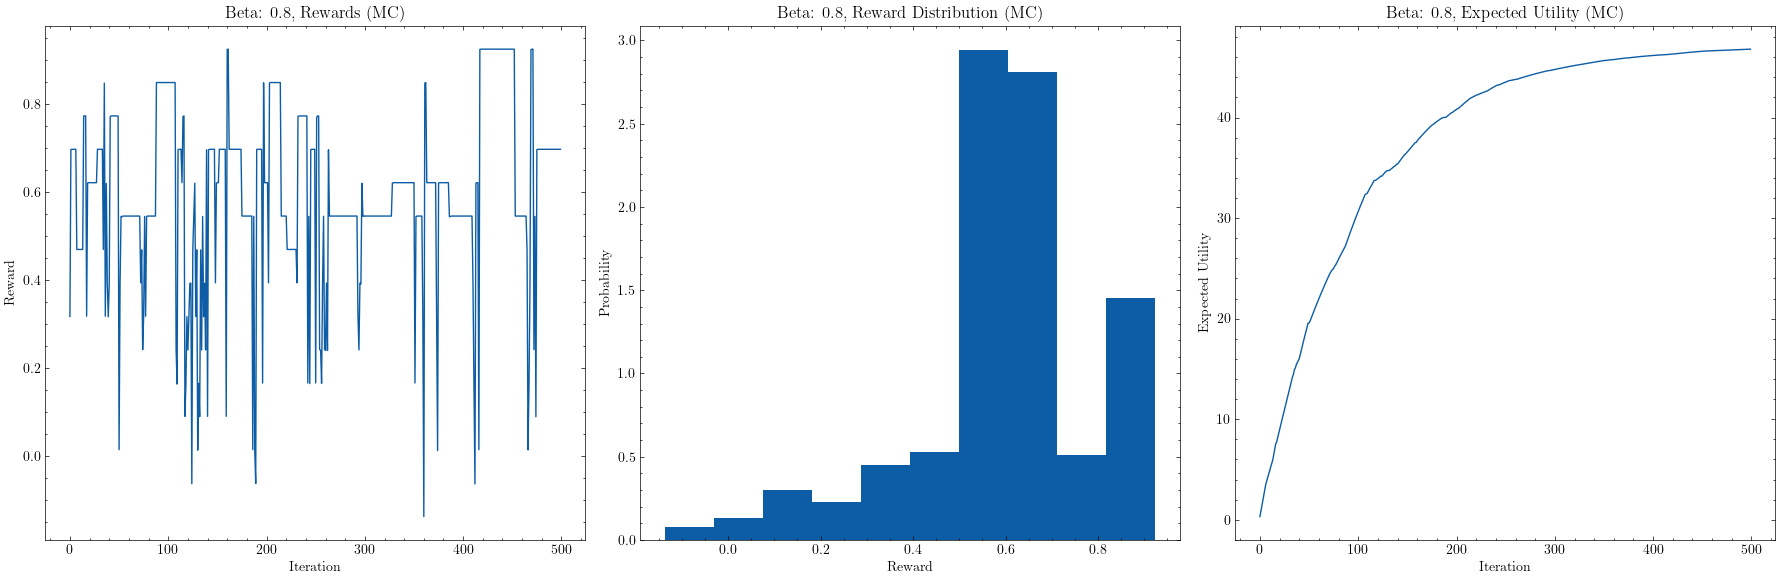

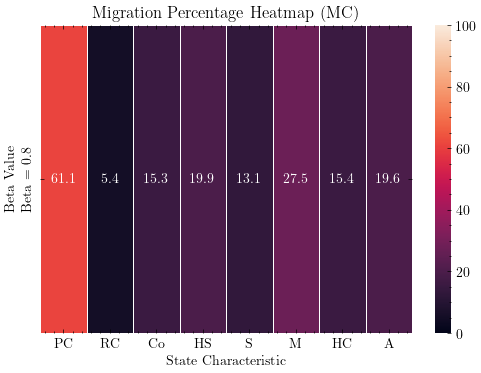

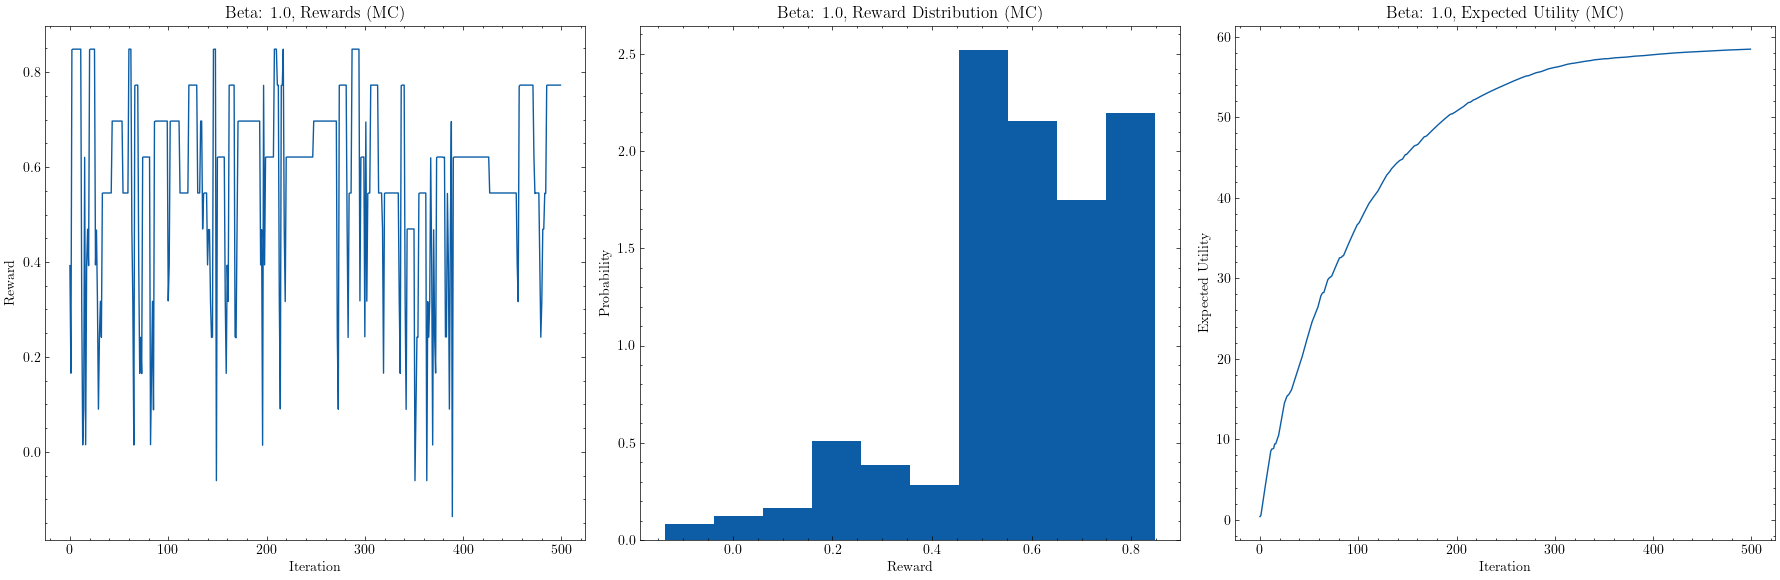

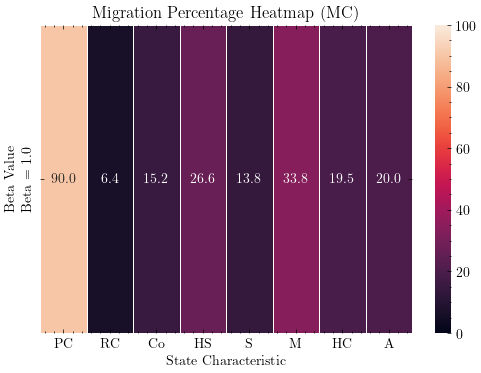

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

beta_values = np.linspace(0, 1, 6)
migration_percentages = []
gam = 0.99
num_iterations = 500
initial_state = StateSpace(Location.POOR_COUNTRY, 0, 2, Education.HIGH_SCHOOL, CurrentLocation.HOME_COUNTRY, RelationshipStatus.SINGLE)

for beta in beta_values:      
    V_cpu, policy = egreedy(states, actions, transition_probabilities, reward_function, beta)
    rewards, expected_utility, migration_percentage, states_sequence, actions_sequence = simulate(initial_state, policy, num_iterations, beta, gam, p1, p2, p3, transition_probabilities)
    plot_results(beta, rewards, expected_utility)
    migration_percentages.append(migration_percentage)
    

    migration_matrix = calculate_migration_percentage_matrix(states_sequence, actions_sequence)

    import matplotlib.ticker as ticker

    # Create heatmaps for all state characteristics
    plt.figure()
    ax = sns.heatmap(migration_matrix * 100, annot=True, xticklabels=["PC", "RC", "Co", "HS", "S", "M", "HC", "A"], yticklabels=[f'Beta = {beta}'], vmin=0, vmax=100, linewidth=.5, fmt=".1f")
    sns.color_palette("mako", as_cmap=True)
    plt.xlabel('State Characteristic')
    plt.ylabel('Beta Value')
    plt.title('Migration Percentage Heatmap (MC)')

    # Format the color bar to display integers
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    plt.show()


#### To plot migration percentage graph:

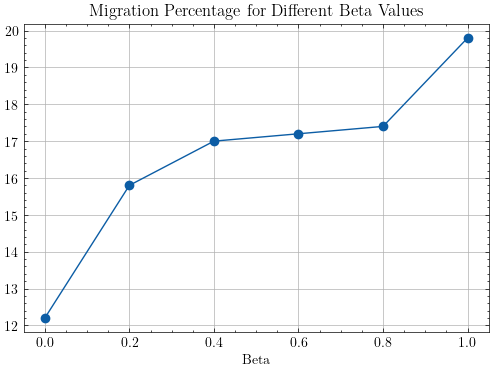

In [19]:
plt.plot(beta_values, migration_percentages, marker='o')
plt.xlabel('Beta')
plt.ylabel('% of Migrate Actions')
plt.title('Migration Percentage for Different Beta Values')
plt.grid(True)
plt.show()

In [20]:
migration_percentages

[12.2, 15.8, 17.0, 17.2, 17.4, 19.8]